# Compare spex with desi_extract_spectra

This was run at jupyter.nersc.gov on a cori shared cpu node with the DESI master kernel.

Generate sample extraction files for comparison on NERSC:

```
#- Setup environement
source /global/cfs/cdirs/desi/software/desi_environment.sh master
cd gpu_specter
export PATH=$(pwd)/bin:$PATH
export PYTHONPATH=$(pwd)/py:$PYTHONPATH

#- Get an interactive node
salloc -N 1 -C haswell -t 60 -q interactive
basedir=/global/cfs/cdirs/desi/spectro/redux/daily/

#- spex
time srun -n 32 -c 2 spex --mpi -w 6000.0,6400.0,0.8 \
    -i $basedir/preproc/20200219/00051060/preproc-r0-00051060.fits \
    -p $basedir/exposures/20200219/00051060/psf-r0-00051060.fits \
    -o $SCRATCH/spex.fits

#- desi_extract_spectra
time srun -n 32 -c 2 desi_extract_spectra --mpi -w 6000.0,6400.0,0.8 \
    -i $basedir/preproc/20200219/00051060/preproc-r0-00051060.fits \
    -p $basedir/exposures/20200219/00051060/psf-r0-00051060.fits \
    -o $SCRATCH/desi_extract.fits
    
```


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import fitsio

## Load extraction samples

In [2]:
spex_filename = os.path.join(os.environ.get("SCRATCH"), 'spex.fits')
desi_filename = os.path.join(os.environ.get("SCRATCH"), 'desi_extract.fits')

In [3]:
# TODO: use desi machinery for loading extraction output?
def read_extract(filename):
    with fitsio.FITS(filename) as fx:
        flux = fx['FLUX'].read().astype('f8')
        ivar = fx['IVAR'].read().astype('f8')
        wave = fx['WAVELENGTH'].read().astype('f8')
    extract = dict(
        flux=flux,
        ivar=ivar,
        wave=wave,
    )
    return extract

In [4]:
spex = read_extract(spex_filename)
desi = read_extract(desi_filename)

## Compare samples

### Wavelength range mismatch

In [5]:
spex['flux'].shape, desi['flux'].shape

((500, 500), (500, 501))

In [6]:
desi['wave'][-10:], spex['wave'][-10:]

(array([6392.8, 6393.6, 6394.4, 6395.2, 6396. , 6396.8, 6397.6, 6398.4,
        6399.2, 6400. ]),
 array([6392. , 6392.8, 6393.6, 6394.4, 6395.2, 6396. , 6396.8, 6397.6,
        6398.4, 6399.2]))

 * It looks like desi_extract_spectra includes the end point in the specified wavelength range

### Flux off by a factor of *dw*

In [7]:
dw = 0.8
nwavestep = 50
nspec = spex['flux'].shape[0]

wave = spex['wave']
wmin, wmax = wave[0], wave[-1]

''

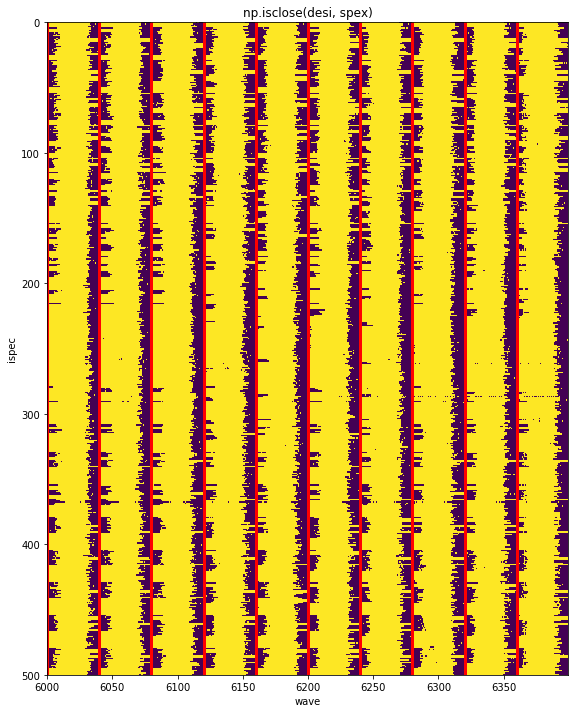

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
extent = [wmin, wmax, nspec, 0]
# TODO: remove dw correction when fixed in spex
# TODO: remove slice on desi flux array when wavelength range fixed in spex
im = ax.imshow(
    np.isclose(desi['flux'][:,:-1], spex['flux']/dw), 
    extent=extent,
    interpolation='none',
)
# Draw red vertical lines at patch wavelength boundary
ax.vlines(np.arange(wmin, wmax, nwavestep*dw), 0, nspec, color='red', lw=3)
ax.set_ylabel('ispec')
ax.set_xlabel('wave')
ax.set_title('np.isclose(desi, spex)')
;